In [3]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

import math

from connect6_game import Connect6  

1.26.0
2.0.1+cu118


In [4]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [5]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden):
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x
        

-0.6588956713676453
[[ 0.  0.  1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0

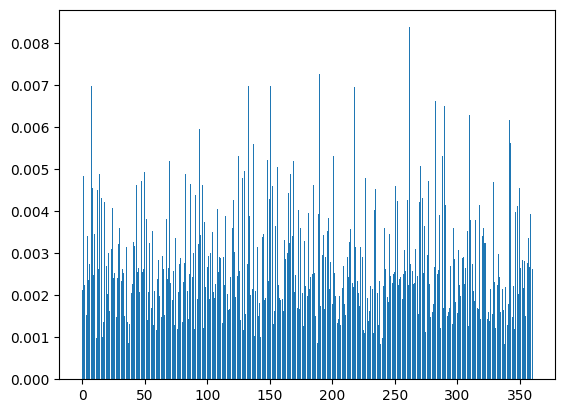

In [6]:
import matplotlib.pyplot as plt

tictactoe = Connect6()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 7, -1)

encoded_state = tictactoe.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [7]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        return child
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)
                
            node.backpropagate(value)    
            
            
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        

In [8]:
tictactoe = Connect6()
player = 1

args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(tictactoe, 4, 64)
model.eval()

mcts = MCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()


while True:
    print(state)
    
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue
            
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = tictactoe.get_next_state(state, action, player)
    
    value, is_terminal = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
        
    player = tictactoe.get_opponent(player)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

ValueError: invalid literal for int() with base 10: ''

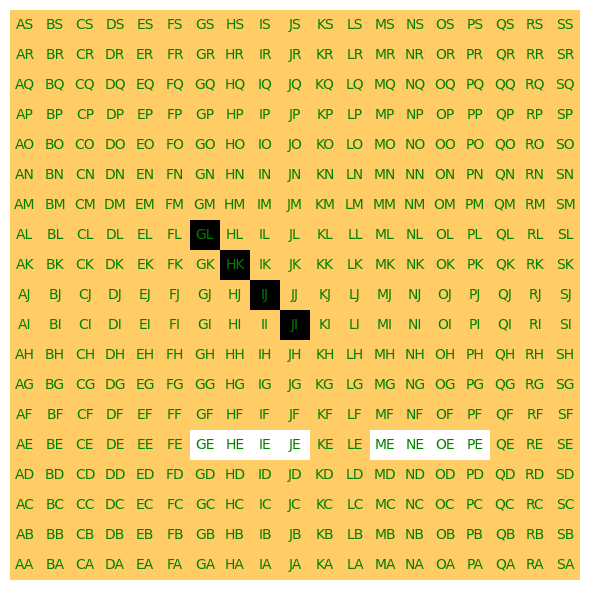

Amenazas jugador:  3
Amenazas oponente:  9


-0.8571428571428572

In [53]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


def show_m_board(m_board):
        """
        Visualizacion del estado del juego
        """

        col = 'ABCDEFGHIJKLMNOPQRS'
        fil = 'SRQPONMLKJIHGFEDCBA'

        # Array de anotaciones de 19x19
        annot = []
        for l1 in fil:
            fila = []
            for l2 in col:
                fila.append(l2 + l1)
            annot.append(fila)

        #Obtener el tablero sin los bordes
        m_board_rep = np.array(m_board)
        m_board_rep = m_board_rep[1:20,1:20]
        
        # Reemplazar los 2 por -1
        m_board_rep = np.where(m_board_rep == 2, -1, m_board_rep)
        
        fontdict = {'fontsize': 10,
                    'fontweight' : 50}
        # Crear un colormap personalizado en el que el negro = 1, blanco = -1 y naranja = 0.
        # Define los colores
        colors = [(1, 1, 1), (1, 0.8, 0.4), (0, 0, 0)]

        # Crea el colormap
        n_bins = 3  
        cmap_name = "custom_colormap"
        cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

        # Normaliza los valores para que estén en el rango [0, 1]
        norm = mcolors.Normalize(vmin=-1, vmax=1)

        plt.figure(figsize=(6,6))
        # Mostrar movimientos sobre el tablero
        plt.imshow(m_board_rep, cmap=cm, norm=norm) 
        
        # Mostrar anotaciones sobre la imagen
        for i in range(19):
            for j in range(19):
                plt.text(j, i, annot[i][j], ha="center", va="center", color="green", fontdict=fontdict)
 
        plt.axis('off')
        plt.tight_layout()
        plt.show()

a = [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 
     [3, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3], 
     [3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3], 
     [3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3], 
     [3, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3], 
     [3, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3], 
     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]


b = [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3], 
     [3, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3], 
     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]

c = [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], 
     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]


def get_threats(m_board, player):
    m_board = np.array(m_board)
    m_board = m_board[1:-1, 1:-1]

    # m_board = np.where(m_board == 2, -1, m_board) * player
    amenazas_jug, amenazas_op = 0, 0
    
    
    # Amenazas horizontales
    for i in range(m_board.shape[0]):
        for j in range(m_board.shape[1] - 6 + 1):

            if np.count_nonzero(m_board[i][j:j+6] == 1) >= 4 and np.count_nonzero(m_board[i][j:j+6] == 0) > 1:
                amenazas_jug += 1
                
            if np.count_nonzero(m_board[i][j:j+6] == 2) >= 4 and np.count_nonzero(m_board[i][j:j+6] == 0) > 1:
                amenazas_op += 1
                
                
    
    # Amenazas verticales
    for col in range(m_board.shape[1]):
        for row in range(m_board.shape[0] - 6 + 1):
            
            if np.count_nonzero(m_board[row:row+6, col] == 1)>=4 and np.count_nonzero(m_board[row:row+6, col] == 0) > 1:
                amenazas_jug += 1
                
            if np.count_nonzero(m_board[row:row+6, col] == 2)>=4 and np.count_nonzero(m_board[row:row+6, col] == 0) > 1:
                amenazas_op += 1

    # Amenazas diagonales
    for k in range(-13, 14):
  
        for i in range(len(np.diag(m_board, k=k)) - 6 + 1):
            v1 = np.diag(m_board, k=k)[i:i+6]
            v2 = np.diag(np.flip(m_board, axis=0), k=k)[i:i+6]

            if np.count_nonzero(v1 == 1) >= 4 and np.count_nonzero(v1 == 0) > 1:
                amenazas_jug += 1


            if np.count_nonzero(v1 == 2) >= 4 and np.count_nonzero(v1 == 0) > 1:
                amenazas_op += 1


            if np.count_nonzero(v2 == 1) >=4 and np.count_nonzero(v2 == 0) > 1:
                amenazas_jug += 1


            if np.count_nonzero(v2 == 2)>=4 and np.count_nonzero(v2 == 0) > 1:
                amenazas_op += 1

    print('Amenazas jugador: ', amenazas_jug)
    print('Amenazas oponente: ', amenazas_op)

    if amenazas_jug == amenazas_op:
        return 0
    
    elif amenazas_jug > amenazas_op:
        diferencia = amenazas_jug - amenazas_op
        return 1 - 1/(1 + diferencia)
    
    else:
        diferencia = amenazas_op - amenazas_jug
        return -1 + 1/(1 + diferencia)       


show_m_board(c)          
get_threats(c, 1)

In [36]:
m_board = np.array(a)
m_board = m_board[1:-1, 1:-1]
for k in range(-13, 14):
    
    print('Fila :', k, np.diag(m_board, k=k))
    # print(np.diag(np.flip(m_board, axis=0), k=k))
    
    for i in range(len(np.diag(m_board, k=k)) - 6 + 1):
        v1 = np.diag(m_board, k=k)[i:i+6]
        v2 = np.diag(np.flip(m_board, axis=0), k=k)[i:i+6]

        if np.count_nonzero(v1 == 1) >= 4 and np.count_nonzero(v1 == 0) > 1:
            print('Amenaza del jugador:', v1)
            amenazas_jug += 1


        if np.count_nonzero(v1 == -1) >= 4 and np.count_nonzero(v1 == 0) > 1:
            print('Amenaza del oponente:', v1)
            amenazas_op += 1


        if np.count_nonzero(v2 == 1)>=4 and np.count_nonzero(v2 == 0) > 1:
            print('Amenaza del jugador:', v2)
            amenazas_jug += 1


        if np.count_nonzero(v2 == -1)>=4 and np.count_nonzero(v2 == 0) > 1:
            print('Amenaza del oponente:', v2)
            amenazas_op += 1
    print('---')
# np.diag(m_board, k=+13)


# 

Fila : -13 [0 0 0 0 0 0]
Ventana  0 [0 0 0 0 0 0]
---
Fila : -12 [0 0 0 0 0 0 0]
Ventana  0 [0 0 0 0 0 0]
Ventana  1 [0 0 0 0 0 0]
---
Fila : -11 [0 0 0 0 0 0 0 0]
Ventana  0 [0 0 0 0 0 0]
Ventana  1 [0 0 0 0 0 0]
Ventana  2 [0 0 0 0 0 0]
---
Fila : -10 [0 0 0 2 0 0 0 0 0]
Ventana  0 [0 0 0 2 0 0]
Ventana  1 [0 0 2 0 0 0]
Ventana  2 [0 2 0 0 0 0]
Ventana  3 [2 0 0 0 0 0]
---
Fila : -9 [0 0 0 0 0 0 0 0 0 0]
Ventana  0 [0 0 0 0 0 0]
Ventana  1 [0 0 0 0 0 0]
Ventana  2 [0 0 0 0 0 0]
Ventana  3 [0 0 0 0 0 0]
Ventana  4 [0 0 0 0 0 0]
---
Fila : -8 [0 0 0 1 0 0 0 0 0 0 0]
Ventana  0 [0 0 0 1 0 0]
Ventana  1 [0 0 1 0 0 0]
Ventana  2 [0 1 0 0 0 0]
Ventana  3 [1 0 0 0 0 0]
Ventana  4 [0 0 0 0 0 0]
Ventana  5 [0 0 0 0 0 0]
---
Fila : -7 [0 0 0 1 0 0 0 0 0 0 0 0]
Ventana  0 [0 0 0 1 0 0]
Ventana  1 [0 0 1 0 0 0]
Ventana  2 [0 1 0 0 0 0]
Ventana  3 [1 0 0 0 0 0]
Ventana  4 [0 0 0 0 0 0]
Ventana  5 [0 0 0 0 0 0]
Ventana  6 [0 0 0 0 0 0]
---
Fila : -6 [0 0 0 1 0 0 0 2 1 0 0 0 1]
Ventana  0 [0 0 0 1 